<a href="https://colab.research.google.com/github/Ridhanya/Neural-Architecture-Search-with-REINFORCE/blob/main/1improvementNASWITHRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Improvements :

1. Now, the loss and model update is for trajectory. Not a single state,action,reward group.
2. Incorporated another value into the search space value tuple to denote if the operation is for conv or dense. Now, an operation j, which is conv is represented as {key:(filter,kernel,"conv1d")}

#Neural Architecture Search with Reinforcement Learning

The main goal of this notebook is to implement a Neural Architecture Search (NAS) framework with conv1D and dense layers as search space, Reinforce policy gradients as Search Strategy and low fidelity estimate (train for few epochs) as the Performance Estimation strategy.

The idea is to use a controller model, which is a Machine Learning (ML) model, to sample ML model configurations for the defined problem statement and adjust it's weights using the reinforce policy gradient strategy with the rewards being the performance of the sampled models. It's weights or parameters are tuned in such a way that it eventually learns to sample only the best model configurations for the problem statement, which is to perform a binary classification using ML to differentiate ventricular arrythmia from other heart diseases using IEGM time series records. Thus, the objective of the controller model would be to sample best ML models for this task.

A simplified plan for the search is mentioned below and our goal would be to implement each of these function under reinforcesearch(). Please note that this is just to set an idea of how the search happens. Therefore, the required arguments and detailed explanations of how configurations are sampled, checked for validity, etc will be clear as the notebook progresses. There are also additional functions (not mentioned below) to log the progress of the search, process the data for the IEGM signal binary classification, etc.


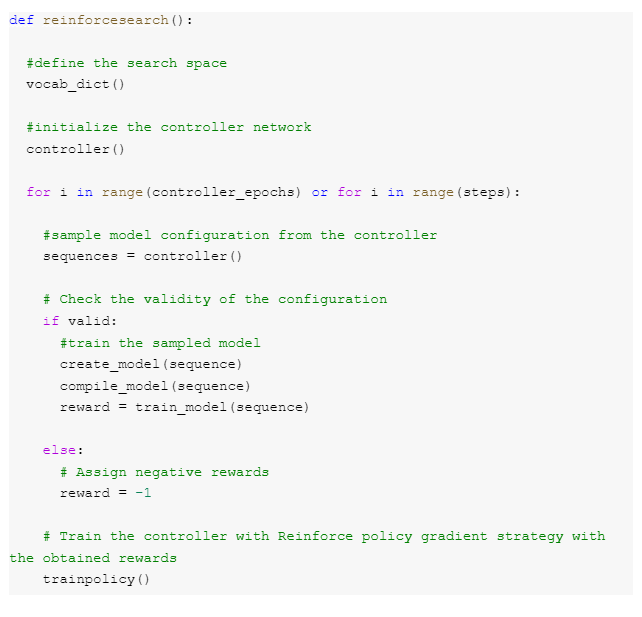

Mount the google drive to this notebook. This is useful if you have to load data available in your drive to this notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Necessary Python Libraries

In [ ]:
import pandas as pd
import pickle
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp

Set seeds for reproducibility if needed

In [ ]:
#add seed values

#Define all the variables to be used in the implementation

In [ ]:
############ Search Space Constants ################

target_classes = 2


############ Main NAS Constants ################

steps = 1000
max_len = 3


############ Controller Constants ################

controller_lstm_dim = 10
controller_lr = 0.01


############ Model generation Constants ################

gen_epochs = 10
mlp_lr = 0.01
mlp_loss_func = 'binary_crossentropy'
metrics = ['accuracy']
batch_size = 256
mlp_dropout = 0.5



############ LOGS - REINFORCERUN.PY #################
nas_data_log = '/content/drive/My Drive/NASWITHRL_aug2023/LOGS/generateddata.pkl'
nas_full_data_log = '/content/drive/My Drive/NASWITHRL_aug2023/LOGS/fulldata.pkl'
validinvalid_log = '/content/drive/My Drive/NASWITHRL_aug2023/LOGS/validinvaliddata.pkl'

#Search Space

Here, the search space is modelled as a dictionary, where the keys of the dictionary point to the operation of a ML architecture. For example, if we have two operations , conv1d(5,3) and conv1d(7,9), the search space dictionary would be {1:(5,3,"conv1d"), 2:(7,9,"conv1d")}. Here, conv1d(x,y) represents one dimensional convolutional neural network with filter size as x and kernel size as y.

In this implementation, dense layers are also added to the search space dictionary as {key : (number of dense nodes, activation function for the layer,"dense"}. For instance, a dense layer with 40 nodes having relu as the activation would be represented as {key : (40,"relu","dense")}. A dropout layer is also a part of the search space and is included in the dictionary as {key : "dropout"}. Please note that here dropout rate is fixed to 0.2

After adding such operations (conv1d,dense and dropout) to the search space, operations for final output dense layer is also appended based on the number of outputs needed for the task. It is added as {key:(target_classes,activation function,"finallayer")}. Here , activation function can be sigmoid or softmax

Overall, a search space dictionary can look like dict = {1:(8,9,"conv1d") , 2:(50,"relu","dense"), 3:(2,"softmax","finallayer")}. (It is just an example. Usually, the length of the dictionary would be much higher)

The function defined below creates a search space in a dictionary format whenever it is called. Check the comments for the complete understanding of each line of code.

In [ ]:
def vocab_dict():

        """
        Takes no arguments. Returns a dictionary

        """

        #define values for the conv1d hyperparameters : kernel size and filter size
        #Here activation function is always relu and strides and padding are one.
        filter_size = [3,5,9,11,13,15,17,19,21,23,25,27,29,31]
        kernel_size = [3,5,9,11,13,15,17,19,21,23,25,27,29,31]

        #create lists to store keys and values of the dictionary
        layer_params = []
        layer_id = []

        #iterate through the specified filter and kernel lists
        for i in range(len(filter_size)):
            for j in range(len(kernel_size)):


                #append (filter, kernel) pairs along with their keys to the lists defined previously
                #please note that here the keys start from 1 and not 0
                layer_params.append((filter_size[i],kernel_size[j],"conv1d"))
                layer_id.append(len(filter_size)*i+j+1)


        #create a search space dictionary from the lists containing (filter, kernel) pairs and their corresponding keys
        vocab = dict(zip(layer_id,layer_params))

        #define values for the number of nodes you want to explore for the dense layers which are usually followed by the conv1d layers
        #Here activation function is always relu, except for the final layer which will be chosen based on the classification tasks (either softmax or sigmoid)
        nodes = [4,8,10,12,16,19,25,50,150,200,300,500]
        act_funcs = ['relu']

        #iterate to make a (num of nodes,activation function) pairs in order to add it to the existing dictionary
        for i in range(len(nodes)):
            for j in range(len(act_funcs)):
                layer_params.append((nodes[i],act_funcs[j],"dense"))
                vocab[len(vocab)+1] = layer_params[-1]

        #add dropout to the dictionary - here dropout size is fixed to 0.2
        vocab[len(vocab)+1] = (('dropout'))

        #add the softmax/sigmoid layer to the dictionary based on the target classes required for the task
        if target_classes == 2:
            vocab[len(vocab)+1] = (target_classes - 1, 'sigmoid','finallayer')
        else:
            vocab[len(vocab)+1] = (target_classes , 'softmax','finallayer')

        return vocab


The function defined below takes the sequence of keys corresponding to operations and the original search space dictionary as the inputs and returns the values corresponding to these keys.

For example : if search space dictionary is defined as dict = {1:(8,9) , 2:(50,"relu"), 3:(2,"softmax")}, and if (3,2) is sent as an input to this function, it would return [(2,"softmax"),(50,"relu")] as the output

This is a supporting function and its uses will be more clear towards the end of the notebook

In [ ]:
def decode_sequence(sequence, vocab):

        """
        Takes a sequence of operations in a tuple or a list (sequence) and search space dictionary (vocab) as inputs.
        Returns the operation associated with keys, specified in the first argument, as defined in the search space dictionary

        """
        keys=list(vocab.keys())
        values = list(vocab.values())
        decoded_sequence = []
        for key in sequence:
            decoded_sequence.append(values[keys.index(key)])
        return decoded_sequence

#Controller Model

The function below defines a Machine Learning (ML) model , often referred to as a controller network, that samples the ML model configurations for the defined problem statement.

Here a LSTM layer with "controller_lstm_dim" number of units along with a final softmax layer is defined as the controller.

In [ ]:
def controllermodel(controller_lstm_dim,controller_input_shape,controller_classes):
    """
    Inputs of the function :
    1. controller_lstm_dim - number of lstm units in the first layer
    2. controller_input_shape - model input shape
    3. controller_classes - model target classes

    Returns the ML model definition as output

    """
    model= tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(controller_lstm_dim, return_sequences=True, input_shape = controller_input_shape, name='main_input'))
    model.add(tf.keras.layers.Dense(controller_classes, activation = 'softmax', name = 'main_output'))
    return model

#Search Strategy

This is based on REINFORCE. Here, the controller model defined above is the policy and reinforce strategy is used to tune the model parameters (weights and biases) to end up with the best policy that gives maximum rewards. That is, the goal is to make the controller model or the policy to sample best ML model operations or actions in order to obtain the maximum validation accuracy or reward on the binary classification task using IEGM dataset.

Here, for each controller epoch, the weights are upated based on the different states of the architectures sampled wihin that epoch. Each of these states are associated with an action and reward. Details of how the actions are sampled, thereby causing changes to the states incuring a reward will be much clear in the main search section.

Loss for a state(s), action(a) and reward (v) group is defined by this equation:
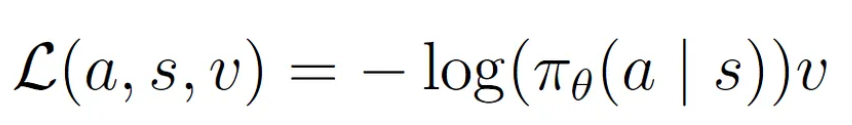

Here pi-tetha(a|s) is the probability of the action sampled given a state by the controller network with it's weights represented as tetha.

In [ ]:
#define the optimizer for the controller model
opt = tf.keras.optimizers.Adam(lr=controller_lr)

#funtion that calculates loss for the policy or the controller model
def a_loss(prob, action, reward):
    """
    Inputs to the function :
    prob - list of probabilities (from softmax /output layer of the controller network) for all the actions or the operations in the search space dictionary
           obtained from the controller model for a state of ML model architecture
    action - operation (key) sampled from the search space dictionary
    reward - reward obtained for the sampled operation or action

    Returns the calculated loss

    """
    #The following two lines find the log of the probability of the action sampled
    #since this action is sampled according to the probabilities of all the actions/operations from the softmax layer of the controller model,
    #we need to select the probability associated with the action sampled. This is exactly what tfp.distributions.Categorical(probs=prob, dtype=tf.float32) does.
    #here prob is the list of probabilities of all the actions or operations

    #example usuage is as follows:
    """
    dist = tfp.distributions.Categorical(probs=[0.1, 0.5, 0.4])
    dist.log_prob(0)
    output : <tf.Tensor: shape=(), dtype=float32, numpy=-2.3025851>

    """
    #here we find log(probability associated with action/operation-1) as our search space keys start from 1 while the tfp.distributions.Categorical
    #takes the index of the first value in the list as 0. That is, if the action or operation sampled is 2, the associated probability will be at the
    #index 1

    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
    log_prob = dist.log_prob(action-1)
    #loss for a (state, action, reward) group
    loss = -log_prob*reward
    return loss

#function that trains the controller network
def trainpolicy(states, rewards, actions,  model, alpha=0.8):
    """
    Input of the function :
    states - list of states of the ML architecture in a controller model epoch
    rewards - list of rewards obtained after each state
    actions - list of actions taken which changed the state of the architecture incurring a reward

    It updates the weights of the controller network directly. Does not return anything.

    """
    #list to store discounted cumulative rewards for each action
    discounted_rewards = []

    #iterate through the rewards list
    for i in range(len(rewards)):
        #For each value in the reward, calculate the discounted cumuative reward and add it to the discounted_rewards list
        cumulative_reward = 0
        for t in rewards[i:]:
            cumulative_reward += (alpha**i)*t
        discounted_rewards.append(cumulative_reward)

    #for each state, pair, action update the parameters of the controller neural network
    #loss is summed up for the trajectory and the parameters of the controller model is updated
    loss = 0
    for state, reward, action in zip(states, discounted_rewards, actions):
        with tf.GradientTape() as tape:
            p = model(np.array(state), training=True)
            loss += a_loss(p, action, reward)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

#Code to generate, train and acquire the reward for the model configuration sampled by the controller network

The function defined below creates a ML model from the configurations sampled by the controller network

In [ ]:
def create_model(sequence,mlp_input_shape,vocab):
        """
        Inputs to the function :
        1. sequence - list of operations sampled by controller model
        2. mlp_input_shape - input shape for the binary classification task using IEGM data
        3. vocab - Search space dictionary

        Returns the model created using the defined operations in sequence

        """

        #variable to track flatten layer
        track=0

        #decode sequence to get details of the layers (nodes,activation)
        layer_configs = decode_sequence(sequence,vocab)

        model= tf.keras.models.Sequential()

        #flatten the input layer for mutli-dimensional inputs
        if(len(mlp_input_shape)>1):
            #input layer
            model.add(tf.keras.layers.Flatten(name='flatten', input_shape=mlp_input_shape))
            #for each element in the layer_configs
            for i, layer_conf in enumerate(layer_configs):
                #First layer after input is always conv or dense
                if i==0:
                    if(layer_conf[2]=="dense"):
                        model.add(tf.keras.layers.Dense(units=layer_conf[0],activation="relu"))
                        track = 1
                    else:
                        model.add(tf.keras.layers.Conv1D(layer_conf[1],layer_conf[0],activation="relu"))
                elif layer_conf == 'dropout' :
                    model.add(tf.keras.layers.Dropout(mlp_dropout, name='dropout'))
                else:
                    if(layer_conf[2] in ("dense", "finallayer")):
                        if(track==0):
                            model.add(tf.keras.layers.Flatten())
                            model.add(tf.keras.layers.Dense(units=layer_conf[0], activation = layer_conf[0]))
                            track=1
                        else:
                            model.add(tf.keras.layers.Dense(units=layer_conf[0], activation = layer_conf[0]))

                    else:
                        model.add(tf.keras.layers.Conv1D(layer_conf[0],layer_conf[1],activation="relu"))

        else:
            #for 1d inputs
            for i,layer_conf in enumerate(layer_configs):

                #add input layer
                #First layer after input is always conv or dense
                if i==0:
                    if(layer_conf[2]=="dense"):
                        model.add(tf.keras.layers.Dense(units=layer_conf[0],activation="relu",input_shape=mlp_input_shape))
                        track = 1
                    else:
                        model.add(tf.keras.layers.Conv1D(layer_conf[1],layer_conf[0],activation="relu",input_shape = (mlp_input_shape[0],1)))
                        firstlayer="conv1d"

                #add subsequent layers
                elif layer_conf == 'dropout':
                    model.add(tf.keras.layers.Dropout(mlp_dropout, name='dropout'))
                else:
                    if(layer_conf[2] in ("dense", "finallayer")):
                        if(track==0):
                            model.add(tf.keras.layers.Flatten())
                            model.add(tf.keras.layers.Dense(units=layer_conf[0], activation = layer_conf[1]))
                            track=1
                        else:
                            model.add(tf.keras.layers.Dense(units=layer_conf[0], activation = layer_conf[1]))

                    else:
                        model.add(tf.keras.layers.Conv1D(layer_conf[1],layer_conf[0],activation="relu"))

        return model


The function defined below is to compile the generated model. Adam optimizer is used and the loss function is defined in the variables section of the notebook.

In [ ]:
def compile_model(model):
        """
        This function takes a model definition (model) as inputs and returns the compiled model

        """
        optim = tf.keras.optimizers.Adam(lr=mlp_lr)
        model.compile(loss=mlp_loss_func,optimizer=optim,metrics=metrics)
        return model

The function defined below is to train the generated model

In [ ]:
def train_model(model,x_data,y_data,nb_epochs, x_val, y_val,callbacks=None):
        """
        Inputs to the function :
        model - compiled model
        x_data, y_data - features and target variable of the IEGM dataset sampled for training
        x_val,y_val - features and target variable of the IEGM dataset sampled for Validation
        callbacks - (optional) List of callbacks. By default, it's None

        Returns the variable containing informations on loss and accuracy of train and validation dataset
        """
        history=model.fit(x_data,y_data,batch_size=batch_size,epochs=nb_epochs,validation_data=(x_val,y_val),callbacks=callbacks,verbose=0)
        return history

The function defined below is to calculate the reward based on the performance of the generated model. The reward here is the weighed average of validation accuracy.

In [ ]:
def rewardforgenmodel(history):
    """
    Inputs to the function  :
    history - the variable containing informations on loss and accuracy of train and validation dataset

    Returns the weighted average of validation accuracy as reward

    """
    if(len(history.history['val_accuracy'])==1):
        return history.history['val_accuracy'][0]

    else:
        return np.ma.average(history.history['val_accuracy'], weights = np.arange(1,len(history.history['val_accuracy'])+1),axis=-1)

#Main Search Function

Here the search space and the controller are initialized, making them ready for the search.

**How does the controller model sample model architectures from the search space and how is the reward given?**

Refer to the following figures. This example show cases how a single controller epoch or a episode would look like if the maximum length of the architecture that we want to search for is 3.

In this example, the initial state is [0,0], which when sent as an input to the controller model, it samples 29 (key of the search space) as the action. This incurs a reward of 0 (a valid action) and the state changes to [29,0]. Now this acts as the input to the controller model, which chooses 100 (key of the search space) as the action, changing the state to [29,100] and incurs a reward of 0. When finally (since the maximum length of architecture to search is 3) [29,100] is sent as an input to the controller model, it samples 210 (key corresponding to the final layer in the search space dictionary) as the action,  making the complete architecture as [29,100,210] and this is trained (after decoding what operation these key value corresponds to in the search space dictionary) for few epochs to obtain the reward as 10* validation accuracy during the training. If the controller model sampled 210 as the action, instead of 100 in the second iteration, [29,210] would be trained to obtain the reward and the episode ends. Note here that all the actions sampled here are valid. That's why episode ended only after the final layer was sampled. If an invalid action was sampled either in the first or second or third iteration, the episode ends and reward obtained at that iteration would be -1. An action is invalid if it points to a dropout or final layer in the first iteration itself. It is also invalid, if a dense layer was sampled in the previous iteration and conv1d operation is sampled in the next. How the validity is determined becomes very clear by reading the comments of the codes below.

In the first iteration -
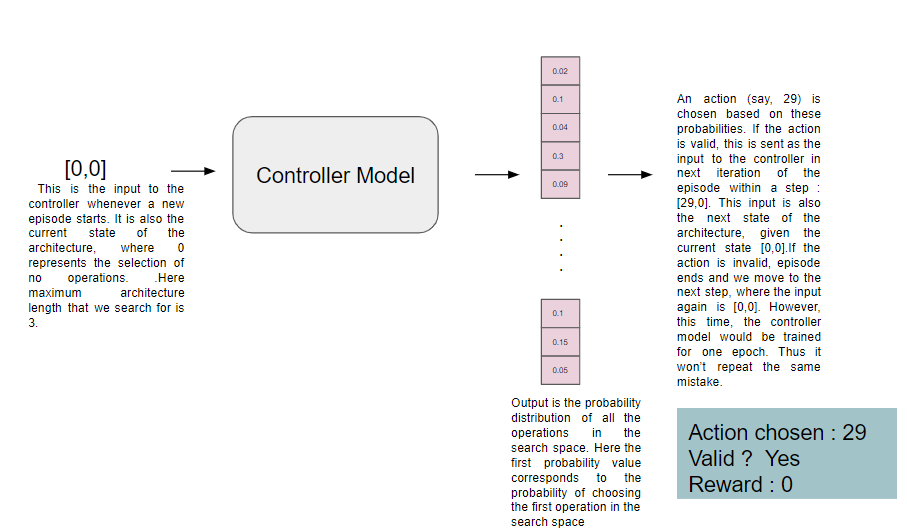

In the second iteration -

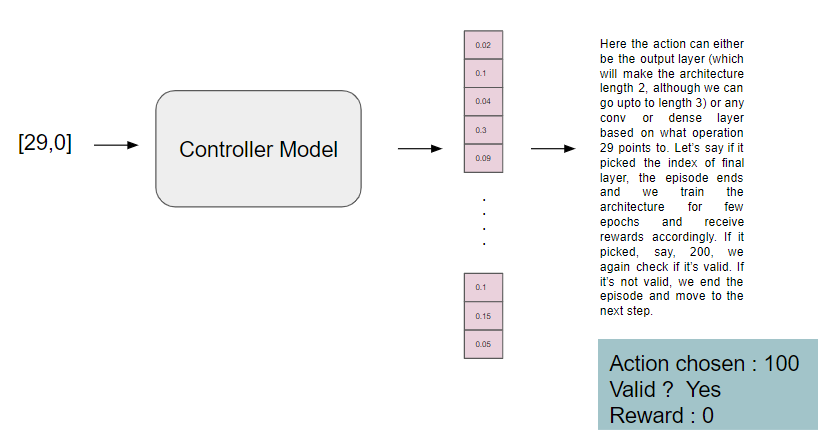

In the third iteration -
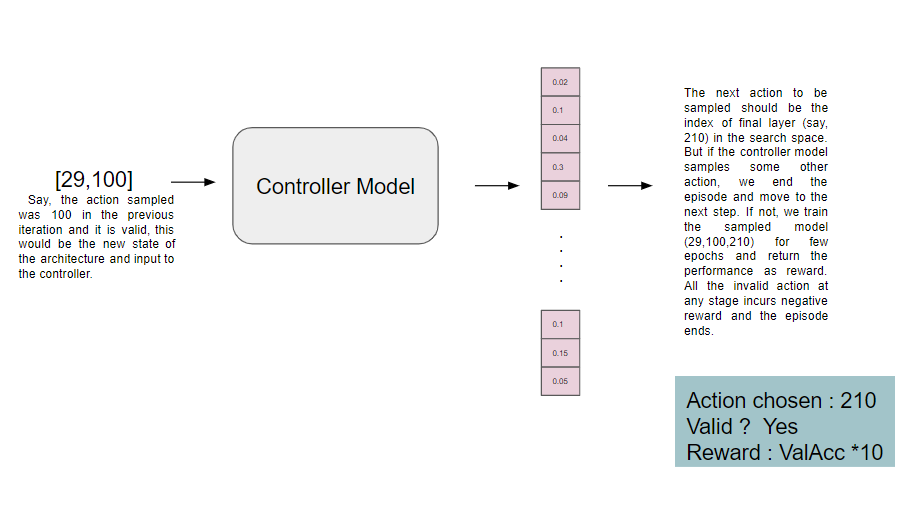

Note here that, the probability values in the images are examples and also the input is not necessarily a list but a numpy array with appropriate size compatible to the input layers of controller model

In [ ]:
def reinforcesearch(input_shape, x_data, y_data, x_val, y_val):

    """
    Inputs of the function :
    1. input_shape : Input shape of the ML model that we intend to search for the problem statement defined
    2. x_data, y_data : IEGM training data's features and target values
    3. x_val,y_val : IEGM validation data's features and target values

    Returns data at each epoch , configurations of all valid models, and a list denoting what kind of configuration (valid or invalid)
    were produced at each controller epoch

    """

    #call the search space
    vocabsearch = vocab_dict()
    #save the keys of the search space in a list.
    vocab_idx = list(vocabsearch.keys())
    #controller model input shape = (1, maximum architecture length to search - 1).
    #maximum architecture length -1 because operations are sampled sequentially one after another.
    controller_input_shape = (1, max_len - 1)
    #define controller classes which is equal to the length of search space dictionary
    controller_classes = len(vocabsearch)

    #The following lists are defined for logging and printing purposes. Their uses can be understood towards the end.
    #data to return
    data = []
    #list to store valid architecture sequence and validation accuracy
    valid_architectures = []
    valid_raw = []
    validrawseqdict = {}

    #initialize controller model
    policymodel = controllermodel(controller_lstm_dim,controller_input_shape,controller_classes)

    #variable to track the number of valid architectures generated over the steps
    validnum = 0
    validinvalidperiter = []

    #iterate over the number of steps which is also the controller training epochs
    for s in range(steps):
        #Define an empty list and add pad them with zeroes. It should match the input size of controller.
        #this will be the current state and will be the first input to the controller model. Basically here the state refers to the state of the architecture.
        sequence=[]
        current_state = tf.keras.utils.pad_sequences([sequence], maxlen= max_len - 1, padding='post').reshape(1,1,max_len - 1,1)
        #define lists to store states, rewards and actions as they are the inputs to the function that trains the controller network at each controller epoch or step
        states, rewards, actions = [], [], []
        #This is to determine when the episode ends and to move to the next step or controller epoch
        done = False

        #episode terminates if the valid architecture is produced and not produced
        while not done :
            #get the output of the policy model gving the current state as input. This is basically the probability distribution of all the operations
            #in the search space
            prob = np.array(policymodel(current_state)[0][0])
            #sample the action that has higher probabilties to occur
            #here, the random choice function makes sure to sample actions that have probabilities comparable to the highest one
            #sampling the highest one always might not let the controller explore
            action = np.random.choice(vocab_idx, size=1, p=(prob/prob.sum()))[0]
            #append the sampled action to the list
            actions.append(action)
            #append the current state to the states list
            states.append(current_state)

            #check for action validity to determine rewards
            #if the first action is the final layer, or the dropout , then it is invalid. It has to be either conv or dense
            #if final layer is not sampled after sampling 2 operations already, then it's invalid
            #if an action samples conv layers and if it already chose dense layer previously, then it's invalid
            #if the action is invalid, a negative reward is given and the episode ends.
            #if an action is valid, it continus to sample operation until the end or when it samples final output layer as the operation after the first layer.
            #Once the final layer is sampled, either at the end or after the first layer, the episode ends.

            #check if the first action is to choose the final output layer and give a negative reward if it's true. End the episode
            if (action == (len(vocabsearch)-1)) and (len(sequence)) == 0:
                reward = -1
                rewards.append(reward)
                done = True
            #check if the first action is to choose the dropout layer and give a negative reward if it's true. End the episode
            elif action == len(vocabsearch) and len(sequence) == 0 :
                reward = -1
                rewards.append(reward)
                done = True
            #if its the last action that has to be sampled, but if it's not the final layer, give a negative reward and end the episode.
            elif (len(sequence) == max_len -1) and action != len(vocabsearch) :
                reward = -1
                rewards.append(reward)
                done = True
            #if its not the first layer
            elif(len(sequence) >=1):
              #This is to check if dense layers are sampled only after the conv1d layers. if a conv layer is sampled and if the controller model has
              #sampled dense layer as the previous operation, then it's invalid and incurs a negative reward. The episode ends.
              if (action < 197 and sequence[-1]>=197):
                        reward = -1
                        rewards.append(reward)
                        done=True
              else:
                            #if it's a valid action and not final output layer indicating the end of the episode, keep adding the sequences
                            if len(sequence) < max_len-1 and action != len(vocabsearch):
                                reward = 0
                                rewards.append(reward)
                                sequence.append(action)

                            #once the sequences list reaches the final layer, train the model.
                            #reward = 10*validation accuracy obtained
                            #end the episode
                            else:
                                #generate the model and train it to get the rewards
                                sequence.append(action)
                                print("sequence in model ", sequence)
                                #if a sequence was already generated in previous steps, we directly takes it's performance instead of retraining
                                if sequence not in valid_raw:
                                    model = create_model(sequence, input_shape, vocabsearch)
                                    compilemodel = compile_model(model)
                                    trainmodel_history = train_model(model,x_data,y_data,gen_epochs, x_val, y_val,callbacks=None)
                                    reward = 10*rewardforgenmodel(trainmodel_history)
                                    print("validation accuracy " , reward/10)
                                    valid_architectures.append([decode_sequence(sequence,vocabsearch),reward/10])
                                    valid_raw.append(sequence)
                                    validrawseqdict[str(sequence)] = reward
                                    rewards.append(reward)
                                    validinvalidperiter.append("valid")
                                else:
                                    rewards.append(validrawseqdict[str(sequence)])
                                    validinvalidperiter.append("repeatedvalid")
                                #count the number of valid architectures sampled so far
                                validnum+=1
                                done=True
            #if all the previous conditions validity conditions got satisfied, then it's a valid action, add it to the sequence and continue with the episode.
            else:
                    reward = 0
                    rewards.append(reward)
                    sequence.append(action)

           #if the episode ended, obtain their rewards and train the controller network with all the states, actions and rewards of the episode
           #else append the obtained state, action and reward. Continue
            if done:
                #train the policy model
                if rewards[-1] == -1:
                    validinvalidperiter.append("invalid")

                print("sequence in controller epoch  "+str(s)+" : ", sequence)
                print("reward in controller epoch  "+str(s)+" : ", sum(rewards))
                data.append([current_state,action,rewards[-1]])
                trainpolicy(states,rewards, actions,policymodel)
            else:
                #add current state, action and rewards received to the data list
                data.append([current_state,action,rewards[-1]])
                #assign next state.For example, if it's the first iteration and the action was valid, next state will be [action,0] if the max len of architecture is 3.
                next_state = tf.keras.utils.pad_sequences([sequence], maxlen= max_len - 1, padding='post').reshape(1,1,max_len - 1,1)
                #this will be the input to the controller model in the next iteration
                current_state = next_state

    return data, valid_architectures , validinvalidperiter

#Perform Architecture Search on your data

In [ ]:
# read the data
#make sure to change the locations if needed
train_data = pd.read_csv('/content/drive/My Drive/NASWITHRL_aug2023/DATA/train.csv')
val_data = pd.read_csv('/content/drive/My Drive/NASWITHRL_aug2023/DATA/val.csv')


# split it into X and y values
x = np.array(train_data.drop(['label','filename','patient_id'], axis=1, inplace=False)).astype('float32')
y = (train_data['label']).values

#do the same for val dataset
x_val = np.array(val_data.drop(['label','filename','patient_id'], axis=1, inplace=False)).astype('float32')
y_val = (val_data['label']).values

# let the search begin
full_data, only_models , validinvalidperiter= reinforcesearch(np.shape(x[0]),x,y,x_val,y_val)


#log data : log of all the valid architectures and their accuracies obtained during the search
with open(nas_data_log, 'wb') as f:
    pickle.dump(only_models, f)

#log data : log of the complete search.
with open(nas_full_data_log, 'wb') as g:
    pickle.dump(full_data, g)

#log data : counts of valid and invalid architectures
with open(validinvalid_log, 'wb') as g:
    pickle.dump(validinvalidperiter, g)

sequence in controller epoch  0 :  [31, 118]
reward in controller epoch  0 :  -1


sequence in controller epoch  1 :  [161, 13]
reward in controller epoch  1 :  -1
sequence in controller epoch  2 :  [6, 83]
reward in controller epoch  2 :  -1
sequence in controller epoch  3 :  [22, 50]
reward in controller epoch  3 :  -1
sequence in controller epoch  4 :  [41, 33]
reward in controller epoch  4 :  -1
sequence in controller epoch  5 :  [205]
reward in controller epoch  5 :  -1
sequence in controller epoch  6 :  [35, 5]
reward in controller epoch  6 :  -1
sequence in controller epoch  7 :  [77, 116]
reward in controller epoch  7 :  -1
sequence in controller epoch  8 :  [73, 113]
reward in controller epoch  8 :  -1
sequence in controller epoch  9 :  [152, 150]
reward in controller epoch  9 :  -1
sequence in controller epoch  10 :  [152, 104]
reward in controller epoch  10 :  -1
sequence in controller epoch  11 :  [204]
reward in controller epoch  11 :  -1
sequence in controller epoch  12 :  [190, 7]
reward in controller epoch  12 :  -1
sequence in controller epoch  13 : 

sequence in model  [113, 48, 210]
validation accuracy  0.887624990940094
sequence in controller epoch  110 :  [113, 48, 210]
reward in controller epoch  110 :  8.87624990940094
sequence in controller epoch  111 :  [3, 82]
reward in controller epoch  111 :  -1
sequence in controller epoch  112 :  [179, 82]
reward in controller epoch  112 :  -1
sequence in controller epoch  113 :  [167, 53]
reward in controller epoch  113 :  -1
sequence in controller epoch  114 :  [40, 137]
reward in controller epoch  114 :  -1
sequence in controller epoch  115 :  [109, 93]
reward in controller epoch  115 :  -1
sequence in controller epoch  116 :  [12, 204]
reward in controller epoch  116 :  -1
sequence in controller epoch  117 :  [128, 9]
reward in controller epoch  117 :  -1
sequence in controller epoch  118 :  [181, 79]
reward in controller epoch  118 :  -1
sequence in controller epoch  119 :  [43, 180]
reward in controller epoch  119 :  -1
sequence in controller epoch  120 :  [163, 29]
reward in cont

validation accuracy  0.8761166366663847
sequence in controller epoch  140 :  [126, 210]
reward in controller epoch  140 :  8.761166366663847
sequence in controller epoch  141 :  [123, 130]
reward in controller epoch  141 :  -1
sequence in controller epoch  142 :  [199, 207]
reward in controller epoch  142 :  -1
sequence in controller epoch  143 :  [50, 60]
reward in controller epoch  143 :  -1
sequence in controller epoch  144 :  [184, 44]
reward in controller epoch  144 :  -1
sequence in controller epoch  145 :  [143, 1]
reward in controller epoch  145 :  -1
sequence in controller epoch  146 :  [132, 125]
reward in controller epoch  146 :  -1
sequence in controller epoch  147 :  [167, 118]
reward in controller epoch  147 :  -1
sequence in controller epoch  148 :  [38, 160]
reward in controller epoch  148 :  -1
sequence in controller epoch  149 :  [175, 136]
reward in controller epoch  149 :  -1
sequence in controller epoch  150 :  [72, 71]
reward in controller epoch  150 :  -1
sequenc

sequence in controller epoch  173 :  [197]
reward in controller epoch  173 :  -1
sequence in controller epoch  174 :  [25, 113]
reward in controller epoch  174 :  -1
sequence in model  [175, 210]
validation accuracy  0.8642854625528509
sequence in controller epoch  175 :  [175, 210]
reward in controller epoch  175 :  8.642854625528509
sequence in controller epoch  176 :  [24, 85]
reward in controller epoch  176 :  -1
sequence in controller epoch  177 :  [188, 52]
reward in controller epoch  177 :  -1
sequence in controller epoch  178 :  [159, 196]
reward in controller epoch  178 :  -1
sequence in controller epoch  179 :  [126, 118]
reward in controller epoch  179 :  -1
sequence in controller epoch  180 :  [91, 189]
reward in controller epoch  180 :  -1
sequence in controller epoch  181 :  [16, 53]
reward in controller epoch  181 :  -1
sequence in controller epoch  182 :  [61, 69]
reward in controller epoch  182 :  -1
sequence in controller epoch  183 :  [173, 6]
reward in controller ep

sequence in model  [144, 147, 210]
validation accuracy  0.906880463253368
sequence in controller epoch  392 :  [144, 147, 210]
reward in controller epoch  392 :  9.06880463253368
sequence in controller epoch  393 :  [88, 143]
reward in controller epoch  393 :  -1
sequence in controller epoch  394 :  [143, 170]
reward in controller epoch  394 :  -1
sequence in controller epoch  395 :  [190, 126]
reward in controller epoch  395 :  -1
sequence in controller epoch  396 :  [148, 180]
reward in controller epoch  396 :  -1
sequence in controller epoch  397 :  [203]
reward in controller epoch  397 :  -1
sequence in controller epoch  398 :  [150, 118]
reward in controller epoch  398 :  -1
sequence in controller epoch  399 :  [27, 145]
reward in controller epoch  399 :  -1
sequence in controller epoch  400 :  [74, 50]
reward in controller epoch  400 :  -1
sequence in controller epoch  401 :  [182, 49]
reward in controller epoch  401 :  -1
sequence in controller epoch  402 :  [111, 19]
reward in 

#References

Search Space design code, controller model design , model generation code (from model config sampled by the controller network) and overall NAS code structure is based on https://github.com/codeaway23/MLPNAS?ref=blog.paperspace.com . The key difference between this github and the notebook is in how the actions are sampled, how the reward is assigned and how the controller model is trained using REINFORCE. In addition to these differences, this notebook has conv1d layers and dense layers as search space operations while MLPNAS (github mentioned before) has only dense layers

Reinforce implementation is based on concepts from : https://towardsdatascience.com/policy-gradients-in-reinforcement-learning-explained-ecec7df94245